# Import of modules


In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import openpyxl
from typing import List, Dict, Optional
import numpy as np
import math

from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import t
from IPython.display import display
from statsmodels.stats import weightstats

# Dictionaries for next changes

In [2]:
school={'GP':0,'MS':1}
sex={'F':0,'M':1}
address={'U':0,'R':1}
family_size={'LE3':0,'GT3':1}
parent_status={'T':0,'A':1}
education={'No_educat':0,'4_classes':1,'5-9_classes':2,'midspec/11_class':3,'hight_educat':4} # desipher
job={'teacher':0, 'health':1, 'services':2, 'at_home':3, 'other':4}
reason={'home':0, 'reputation':1, 'course':2, 'other':3}
guardian={'mother':0, 'father':1, 'other':2}
travel_time={'<15 m':1,'15-30 m':2,'30-60 m':3,'>60 m':4}  # desipher
study_time={'<2 h':1,'2-5 h':2,'5-10 h':3,'>10 h':4}  # desipher
yes_no_colm={'no':0,'yes':1}

#  Functions blocks

In [3]:
# Function for calculating percentiles
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'Q_%s' % (n//25)
    return percentile_

In [4]:
# Function for plotting the boxplots and table for 1 column
def obj_plots(column, df):
    # Create statistic table for column score groupped by testing column
    column_stats = df.groupby(by=column)['score'].agg(['count', 'mean', 'std', 'median',
                                                       'min', 'max', percentile(25), percentile(75)])
    # Remove values that numbers less than 5 (not significant)
    column_stats = column_stats[column_stats['count'] > 5]

    if len(column_stats) > 1: # Testing that we still have something to test)
        # Plot the pattern for boxplots and statistic table
        fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [6, 1]})

        # Configure title and axes lables
        axes[0].set_title('Boxplot of scores by')
        axes[0].xaxis.set_label_position('top')
        axes[0].xaxis.tick_top()
        axes[1].axis('tight')
        axes[1].axis('off')

        # Find significant diference
        stat_result_2 = get_stat_dif(column, df)

        # Set table name
        axes[1].set_title(stat_result_2)

        # Plot the statistic table
        table = axes[1].table(cellText=np.round(column_stats.values.tolist(), 1),
                              colLabels=column_stats.columns,
                              rowLabels=column_stats.index)
        # Configure table parametrs
        table.auto_set_font_size(False)
        table.set_fontsize(14)

        # Plot the boxplot for scores, calculated by used column
        sns.boxplot(ax=axes[0], x=column,
                    y='score',
                    data=df)

        # Plot the figure
        plt.show()

In [5]:
# Function for finding significant difference
def get_stat_dif(column_1, df):
    cols = df.loc[:, column_1].value_counts().index # Use unique values for next calculations
    combinations_all = list(combinations(cols, 2)) # Create combination table for finding significant difference

    for comb in combinations_all: # Testing all combinations

        # values of finding frame length
        n_comb_0 = len(df.loc[df.loc[:, column_1] == comb[0], 'score'])
        n_comb_1 = len(df.loc[df.loc[:, column_1] == comb[1], 'score'])

        # Test the data frame account for frames length
        if (n_comb_0 > 5 and n_comb_1 > 5) and (ttest_ind(df.loc[df.loc[:, column_1] == comb[0], 'score'],
                                                          df.loc[df.loc[:, column_1] == comb[1], 'score']).pvalue \
                                                <= 0.05 / len(combinations_all)):  # Учли поправку Бонферони
            # If data Frame have significant diference return informaniton about it
            return 'There are significant diference for colunm ' + column_1

    # If data Frame have no significant diference return informaniton about it
    return "There aren't significant diference for colunm " + column_1

In [6]:
# Function for turn NaN Values in object column into None
def nan_to_none(column):
    return pupil_math[column].apply(lambda x: None if pd.isnull(x) else x)

# Import information from file and first look at data set

In [7]:
pd.set_option('display.max_rows', 50) # Show more rows
pd.set_option('display.max_columns', 50) # Show more columns

In [8]:
pupil_math=pd.read_csv('stud_math.csv') # File import

display(pupil_math.columns) # Show original columns names
display(pupil_math.head(10)) # Show first 10 rows
pupil_math.info() # Show DS info

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [9]:
# Change columns names for next analysis
pupil_math.columns=['school', 'sex', 'age', 'address', 'family_size', 'parent_status', 'mother_education',
                    'father_education', 'mother_job', 'father_job', 'reason', 'guardian', 'travel_time', 'study_time',
                    'failures', 'schools_up', 'familys_up', 'paid_courses', 'activities', 'nursery', 'study_time_granular',
                    'thought_higher_eduaction', 'internet', 'romantic', 'family_relations','free_time', 'go_out',
                    'health', 'absences', 'score']

# Combine object columns (after first analysis)
obj_columns=['school','sex','address','family_size','parent_status','mother_job','father_job','reason','guardian',
             'schools_up','familys_up','paid_courses','activities','nursery','thought_higher_eduaction','internet',
             'romantic','mother_education','father_education','travel_time','study_time']

# Combine numerical columns (after first analysis)
num_columns=['age',  'failures', 'family_relations', 'free_time', 'go_out', 'health', 'absences', 'score']

,age,mother_education,father_education,travel_time,study_time,failures,study_time_granular,family_relations,free_time,go_out,health,absences,score
age,1.000000,-0.161704,-0.138018,0.081508,-0.015556,0.228047,0.015556,0.068899,0.029023,0.135107,-0.065946,0.093592,-0.155726
mother_education,-0.161704,1.000000,0.275598,-0.173515,0.078589,-0.245463,-0.078589,-0.010050,0.025335,0.064164,-0.045051,-0.011944,0.213349
father_education,-0.138018,0.275598,1.000000,0.030646,0.057199,-0.150821,-0.057199,0.040577,-0.066556,-0.023282,0.027251,0.004695,0.078573
travel_time,0.081508,-0.173515,0.030646,1.000000,-0.102206,0.064699,0.102206,-0.016857,-0.021937,0.037636,-0.021531,-0.048215,-0.070559
study_time,-0.015556,0.078589,0.057199,-0.102206,1.000000,-0.178992,-1.000000,0.045894,-0.121969,-0.051280,-0.080016,-0.026544,0.115741
failures,0.228047,-0.245463,-0.150821,0.064699,-0.178992,1.000000,0.178992,-0.022655,0.098382,0.120914,0.081284,0.057391,-0.344338
study_time_granular,0.015556,-0.078589,-0.057199,0.102206,-1.000000,0.178992,1.000000,-0.045894,0.121969,0.051280,0.080016,0.026544,-0.115741
family_relations,0.068899,-0.010050,0.040577,-0.016857,0.045894,-0.022655,-0.045894,1.000000,0.175743,0.081154,0.077474,-0.082609,0.057112
free_time,0.029023,0.025335,-0.066556,-0.021937,-0.121969,0.098382,0.121969,0.175743,1.000000,0.296437,0.061575,0.009292,0.019026
go_out,0.135107,0.064164,-0.023282,0.037636,-0.051280,0.120914,0.051280,0.081154,0.296437,1.000000,-0.015608,-0.048738,-0.129685


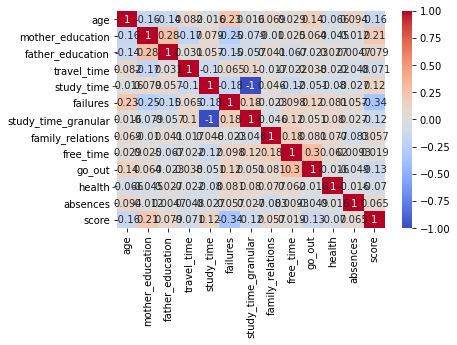

In [10]:
# Show heat map and correlation table for data in DS
sns.heatmap(pupil_math.corr(), annot=True, cmap='coolwarm')
display(pupil_math.corr())

# After first review we can make next desicions

In [11]:
# Remove rows without scores, as they have no sence
pupil_math = pupil_math.loc[pupil_math.score.notnull()]

# Remove column study_time_granular because it correlates with study_time (correlation 	coefficient is -1)
pupil_math.drop(['study_time_granular'], inplace = True, axis = 1)

# Review every data series for remove useless information

In [12]:
# Show all unique values and it's count
for col in pupil_math.columns:
    display(f'Counts of uniqe values of column "{col}"',pd.DataFrame(pupil_math[col].value_counts()))

'Counts of uniqe values of column "school"'

,school
GP,344
MS,45


'Counts of uniqe values of column "sex"'

,sex
F,204
M,185


'Counts of uniqe values of column "age"'

,age
16,103
17,98
15,82
18,80
19,21
20,3
22,1
21,1


'Counts of uniqe values of column "address"'

,address
U,291
R,83


'Counts of uniqe values of column "family_size"'

,family_size
GT3,255
LE3,107


'Counts of uniqe values of column "parent_status"'

,parent_status
T,308
A,36


'Counts of uniqe values of column "mother_education"'

,mother_education
4.0,131
2.0,100
3.0,96
1.0,56
0.0,3


'Counts of uniqe values of column "father_education"'

,father_education
2.0,105
3.0,94
4.0,88
1.0,75
0.0,2
40.0,1


'Counts of uniqe values of column "mother_job"'

,mother_job
other,127
services,98
at_home,58
teacher,55
health,32


'Counts of uniqe values of column "father_job"'

,father_job
other,194
services,99
teacher,29
at_home,16
health,15


'Counts of uniqe values of column "reason"'

,reason
course,135
reputation,102
home,101
other,34


'Counts of uniqe values of column "guardian"'

,guardian
mother,248
father,86
other,24


'Counts of uniqe values of column "travel_time"'

,travel_time
1.0,239
2.0,94
3.0,21
4.0,7


'Counts of uniqe values of column "study_time"'

,study_time
2.0,189
1.0,103
3.0,63
4.0,27


'Counts of uniqe values of column "failures"'

,failures
0.0,290
1.0,48
2.0,15
3.0,14


'Counts of uniqe values of column "schools_up"'

,schools_up
no,331
yes,49


'Counts of uniqe values of column "familys_up"'

,familys_up
yes,216
no,135


'Counts of uniqe values of column "paid_courses"'

,paid_courses
no,197
yes,153


'Counts of uniqe values of column "activities"'

,activities
yes,192
no,183


'Counts of uniqe values of column "nursery"'

,nursery
yes,297
no,77


'Counts of uniqe values of column "thought_higher_eduaction"'

,thought_higher_eduaction
yes,350
no,19


'Counts of uniqe values of column "internet"'

,internet
yes,300
no,55


'Counts of uniqe values of column "romantic"'

,romantic
no,235
yes,123


'Counts of uniqe values of column "family_relations"'

,family_relations
4.0,178
5.0,97
3.0,62
2.0,17
1.0,7
-1.0,1


'Counts of uniqe values of column "free_time"'

,free_time
3.0,152
4.0,110
2.0,63
5.0,37
1.0,18


'Counts of uniqe values of column "go_out"'

,go_out
3.0,126
2.0,101
4.0,81
5.0,51
1.0,23


'Counts of uniqe values of column "health"'

,health
5.0,137
3.0,88
4.0,60
1.0,47
2.0,42


'Counts of uniqe values of column "absences"'

,absences
0.0,110
2.0,60
4.0,52
6.0,30
8.0,20
10.0,17
12.0,12
14.0,12
3.0,7
16.0,7


'Counts of uniqe values of column "score"'

,score
50.0,54
55.0,46
0.0,37
75.0,33
65.0,31
40.0,31
60.0,31
70.0,27
45.0,27
80.0,16


## After data review we can make next desicions:
### 1)   In column "age" there aren't enough values of more than 19 for analysis. Turn them into None
### 2)   In columns "mother_education" and "father_education' there are not enough values of less than 1.
###       Turn them into None
### 3)   In column "father_education" there is one outlier (40). Turn it into None
### 4)   In column "family_relations there is one outlier (-1). Turn it into None
### 5)   Columns "absence" and "score" need more analysing for removeing outliers
### 6)   Column "score" has zero (0) values. it's obviously useless data. Remove it.

In [13]:
# Turn to None age that does not make sence in data set.
pupil_math.age = pupil_math.age.apply(lambda x: None if x>19 else x)
# Turn to None all outliers in column father_education and mother_education
pupil_math.father_education=pupil_math.father_education.apply(lambda x: None if x<1 or x>4 else x)
pupil_math.mother_education=pupil_math.mother_education.apply(lambda x: None if x<1 or x>4 else x)
# Turn to None all outliers in column family_relations
pupil_math.family_relations=pupil_math.family_relations.apply(lambda x: None if x<1 or x>5 else x)
# Remove 0 scores from data set
pupil_math = pupil_math.loc[pupil_math.score>0]

In [14]:
# Desipher columns education, travel and study time for more clarity
pupil_math.father_education=pupil_math.father_education.apply\
    (lambda x: list(education.keys())[list(education.values()).index(int(x))] if not(pd.isnull(x)) else x)
pupil_math.mother_education=pupil_math.mother_education.apply\
    (lambda x: list(education.keys())[list(education.values()).index(int(x))] if not(pd.isnull(x)) else x)
pupil_math.travel_time=pupil_math.travel_time.apply\
    (lambda x: list(travel_time.keys())[list(travel_time.values()).index(int(x))] if not(pd.isnull(x)) else x)
pupil_math.study_time=pupil_math.study_time.apply\
     (lambda x: list(study_time.keys())[list(study_time.values()).index(int(x))] if not(pd.isnull(x)) else x)

In [15]:
#replace all values NaN to None in all columns
for col in pupil_math.columns:
    pupil_math[col]=nan_to_none(col)

In [16]:
# Calculate and display outliers for column "absense"
IQR = pupil_math.absences.quantile(0.75) - pupil_math.absences.quantile(0.25) # Calculate interquartile range
perc25 = pupil_math.absences.quantile(0.25) # Calculate first quartile
perc75 = pupil_math.absences.quantile(0.75) # Calculate therd quartile
print('25-percentile: {},'.format(perc25), '75-percentile: {},'.format(perc75), "IQR: {}, ".format(IQR),
      "Range of outliers: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-percentile: 2.0, 75-percentile: 8.0, IQR: 6.0,  Range of outliers: [-7.0, 17.0].


In [17]:
display(pupil_math[pupil_math.absences>(perc75 + 1.5*IQR)][['absences','score']].describe(), 
        pupil_math[pupil_math.absences>(perc75 + 1.5*IQR)].absences.value_counts(bins=20, sort=False),
        pupil_math[pupil_math.absences>(perc75 + 1.5*IQR)][['absences','score']])

,absences,score
count,27.000000,27.000000
mean,47.851852,51.481481
std,77.367606,17.857061
min,18.000000,20.000000
25%,20.000000,40.000000
50%,22.000000,50.000000
75%,34.000000,62.500000
max,385.000000,90.000000


(17.631999999999998, 36.35]    20
(36.35, 54.7]                   3
(54.7, 73.05]                   1
(73.05, 91.4]                   1
(91.4, 109.75]                  0
(109.75, 128.1]                 0
(128.1, 146.45]                 0
(146.45, 164.8]                 0
(164.8, 183.15]                 0
(183.15, 201.5]                 0
(201.5, 219.85]                 1
(219.85, 238.2]                 0
(238.2, 256.55]                 0
(256.55, 274.9]                 0
(274.9, 293.25]                 0
(293.25, 311.6]                 0
(311.6, 329.95]                 0
(329.95, 348.3]                 0
(348.3, 366.65]                 0
(366.65, 385.0]                 1
Name: absences, dtype: int64

,absences,score
40,25.0,55.0
74,54.0,55.0
89,18.0,35.0
103,26.0,30.0
118,20.0,40.0
123,18.0,65.0
183,56.0,40.0
198,24.0,90.0
203,18.0,30.0
205,28.0,45.0


In [18]:
# After analyzing data frame make the desicion to remove all rows containing values more than 34 (75 percentile)
pupil_math = pupil_math.loc[pupil_math.absences<=34]

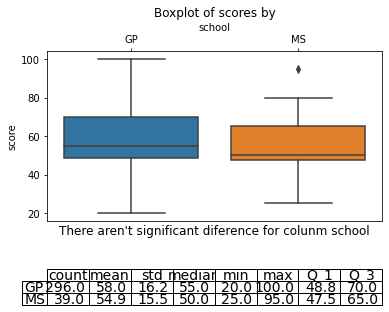

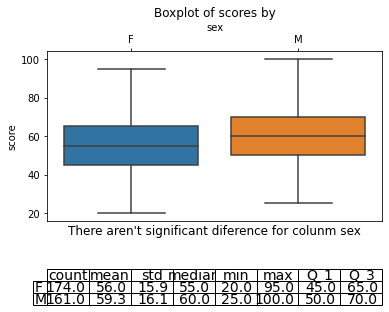

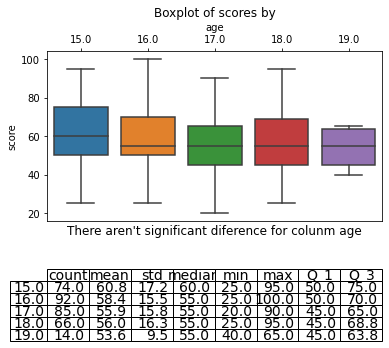

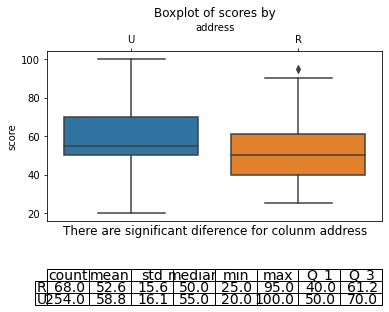

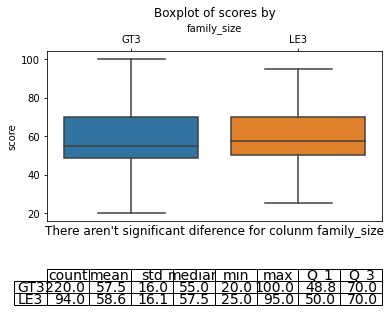

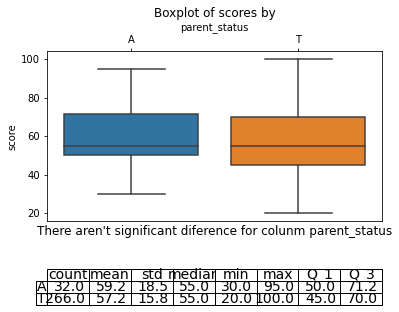

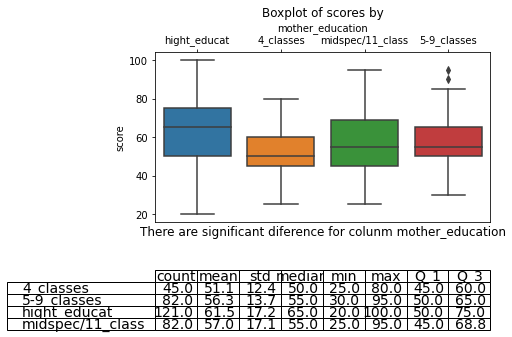

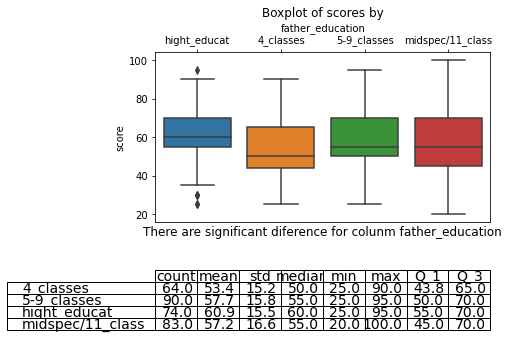

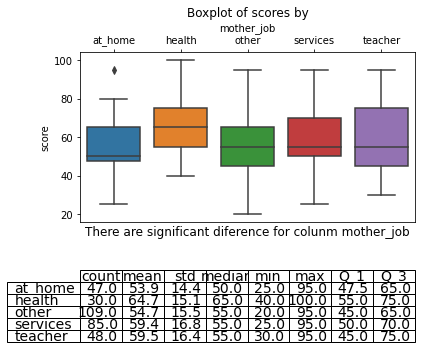

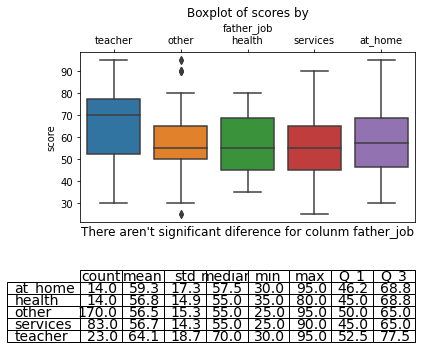

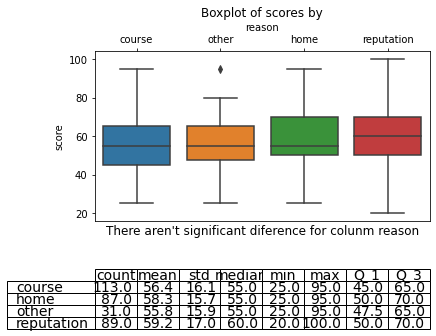

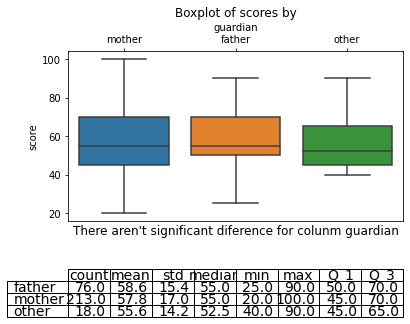

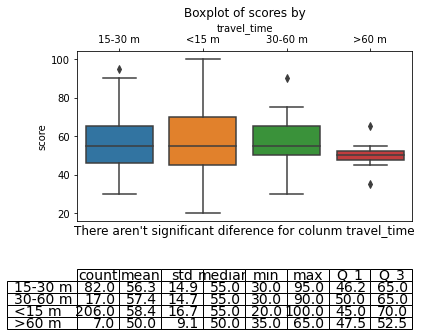

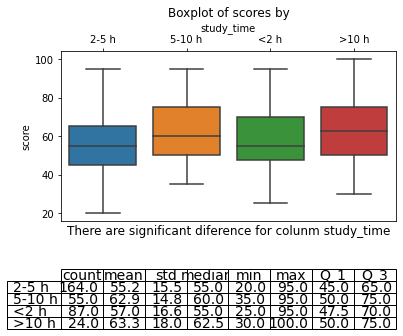

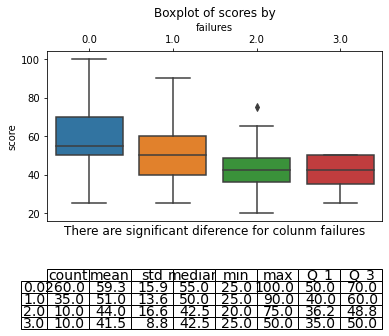

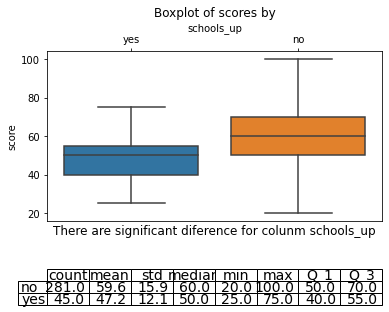

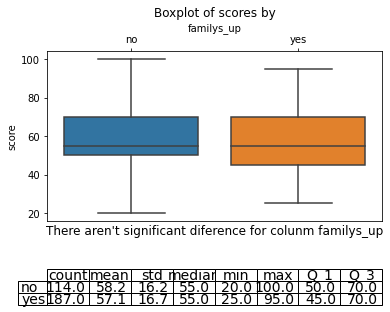

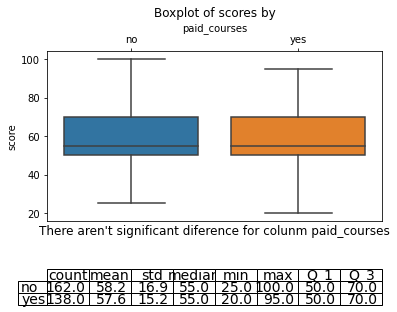

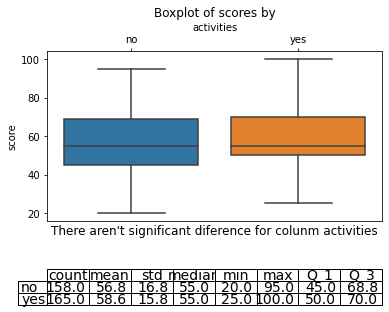

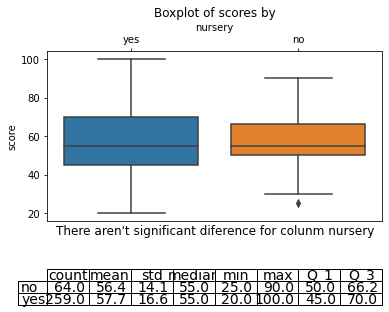

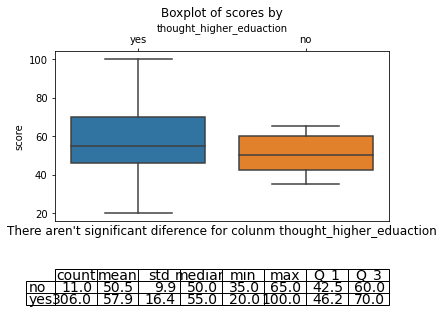

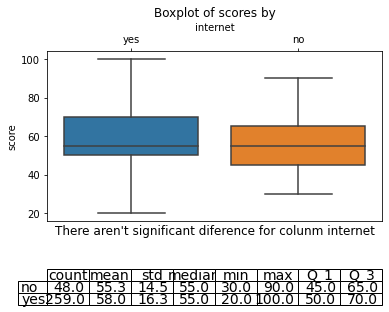

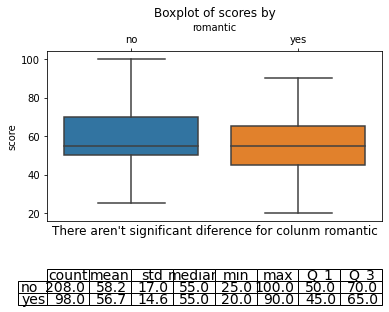

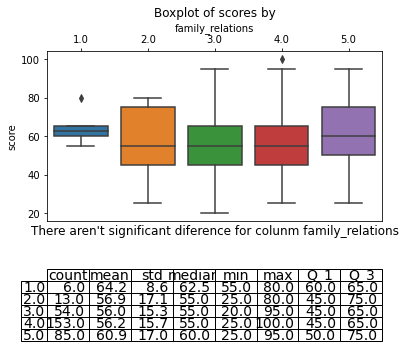

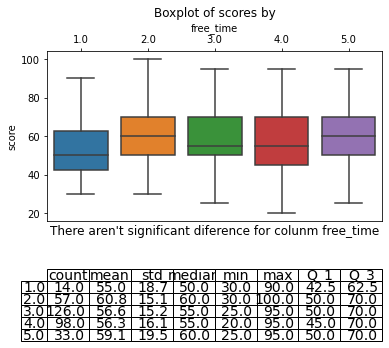

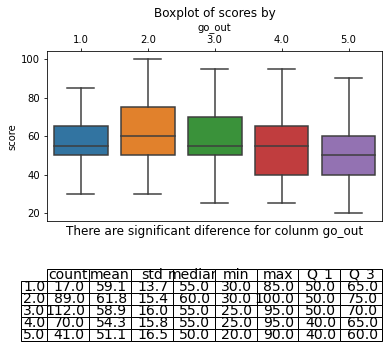

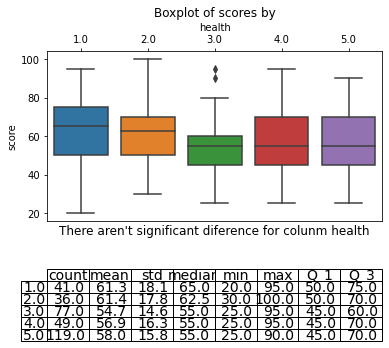

In [19]:
# Find significant diference for all columns
meaning_columns_d1 = []  # List for saving the information about columns that have significant diference
for col in pupil_math.columns[:-2]:  # Column absence will be test single

    obj_plots(col, pupil_math)  # Plot information about column
    # Test for significant diference
    if get_stat_dif(col,pupil_math) == 'There are significant diference for colunm ' + col:
        meaning_columns_d1.append(col)

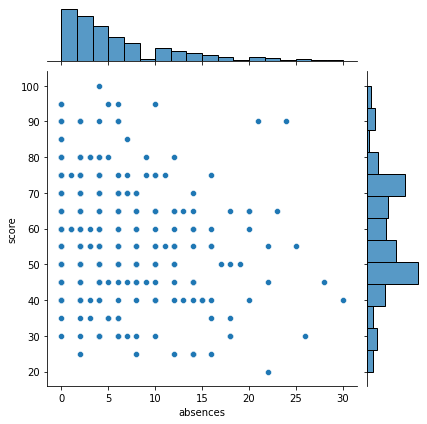

In [20]:
# Plot the figure of depending absences and score
sns.jointplot(x='absences', y='score', data=pupil_math) 
plt.show()

<AxesSubplot:>

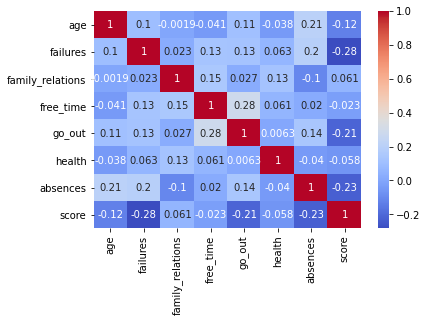

In [21]:
# Display correlation heatmap for numerical columns
sns.heatmap(pupil_math.corr(), annot=True, cmap='coolwarm') 

In [22]:
display('Columns with significant diference',meaning_columns_d1)

'Columns with significant diference'

['address',
 'mother_education',
 'father_education',
 'mother_job',
 'study_time',
 'failures',
 'schools_up',
 'go_out']

# First analysis allowes us to make the following conclutions
## 1) the significant columns are adress, mother_education, father_education, mother_job, study_time,
# failures, schools_up, go_out.
## 2) Column absence, age and go_out have negative correlation with score
## 3) For further analysis let us sort data set into groups.

'There are significant diference for colunm school devided by family_size in GT3'

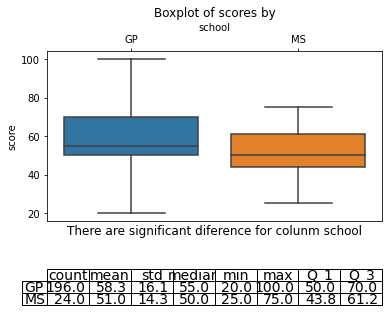

'There are significant diference for colunm sex devided by age in 15.0'

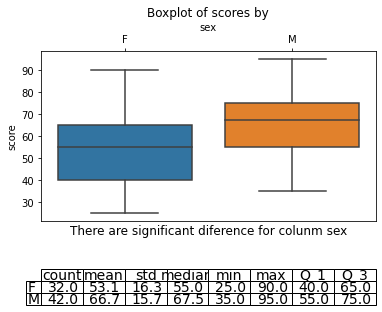

'There are significant diference for colunm sex devided by age in 16.0'

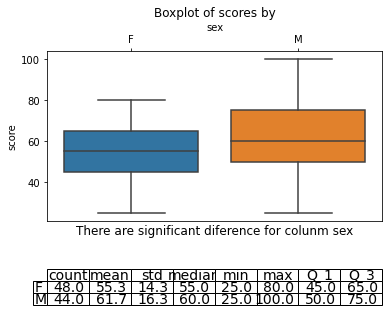

'There are significant diference for colunm sex devided by family_size in GT3'

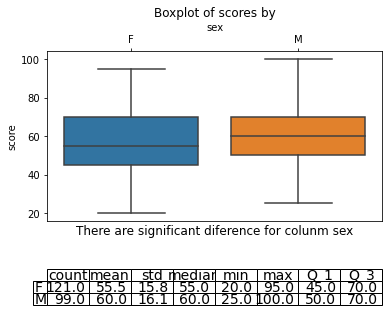

'There are significant diference for colunm sex devided by parent_status in A'

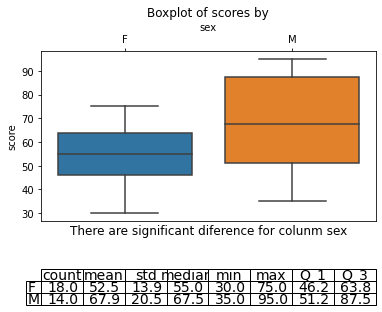

'There are significant diference for colunm sex devided by father_job in other'

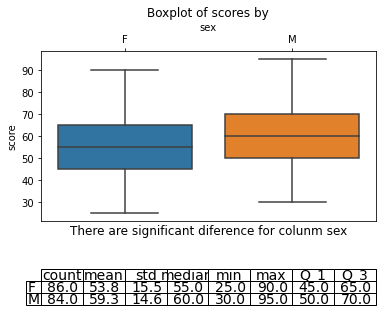

'There are significant diference for colunm sex devided by father_job in teacher'

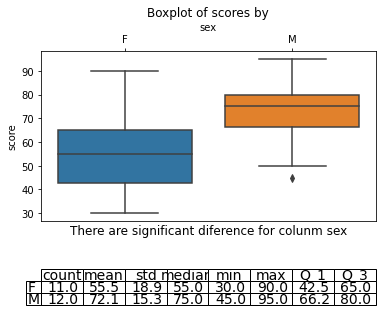

'There are significant diference for colunm sex devided by guardian in mother'

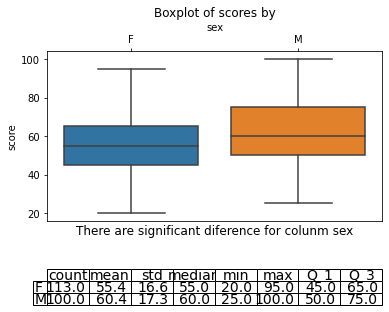

'There are significant diference for colunm sex devided by travel_time in <15 m'

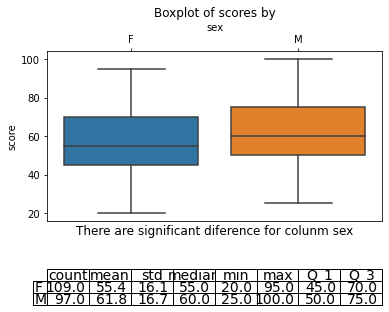

'There are significant diference for colunm sex devided by familys_up in yes'

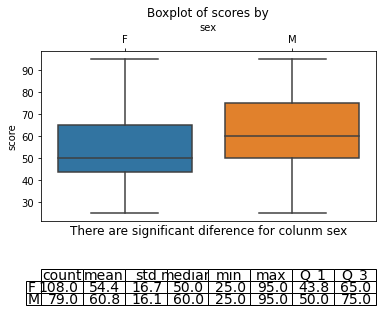

'There are significant diference for colunm sex devided by thought_higher_eduaction in yes'

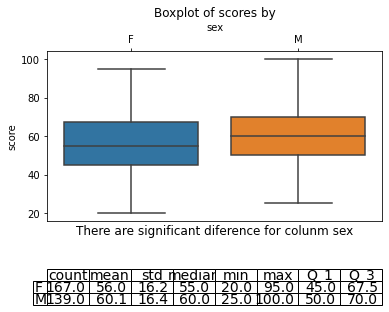

'There are significant diference for colunm sex devided by free_time in 3.0'

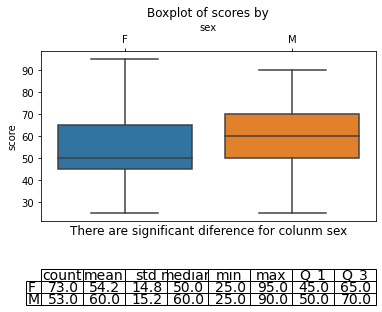

'There are significant diference for colunm sex devided by health in 4.0'

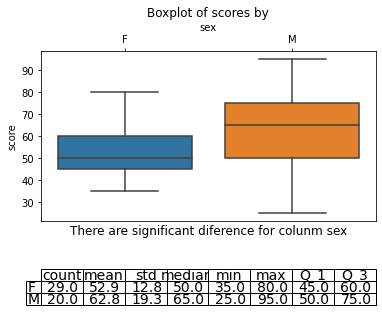

'There are significant diference for colunm age devided by health in 5.0'

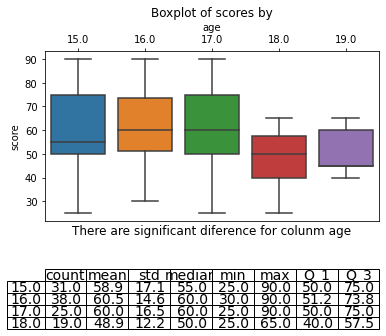

'There are significant diference for colunm reason devided by paid_courses in yes'

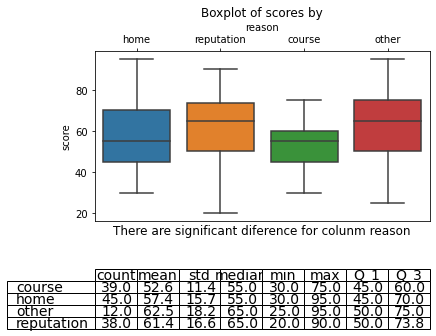

'There are significant diference for colunm reason devided by nursery in no'

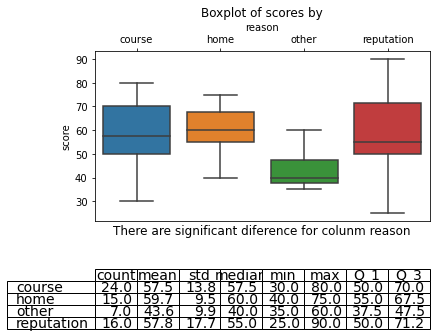

'There are significant diference for colunm activities devided by free_time in 3.0'

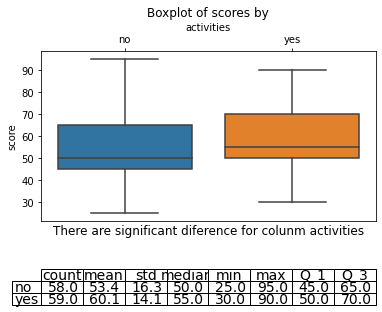

'There are significant diference for colunm activities devided by health in 5.0'

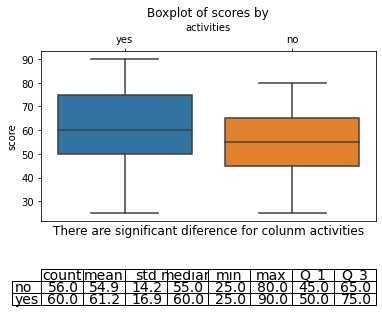

'There are significant diference for colunm romantic devided by family_relations in 5.0'

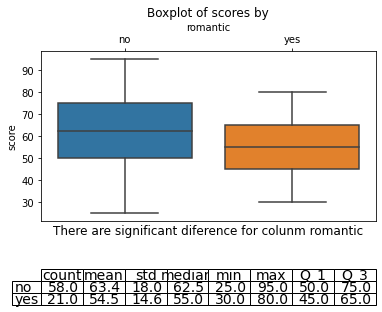

'There are significant diference for colunm family_relations devided by free_time in 4.0'

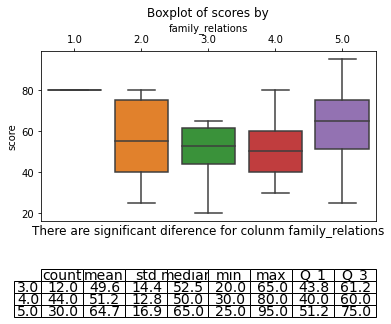

In [23]:
# Analyze data groups for unsignificant columns
meaning_datas_d2=[] # List for log of data analyze
meaning_column_d2=[] # List for saving information about columns that have significant diference
columns_numb=len(pupil_math.columns.tolist()[:-2])

for i in range(columns_numb):
            for j in range(i + 1, columns_numb):

                # Exclude from analysis columns with hight significant diference
                if (pupil_math.columns[i] not in meaning_columns_d1) \
                        and (pupil_math.columns[j] not in meaning_columns_d1):

                    # create statistic table for data frames and remove values less that 5
                    data_frame = pupil_math.groupby(by=pupil_math.columns[j])['score']\
                        .agg(['count', 'mean', 'std', 'median', 'min', 'max', percentile(25), percentile(75)])
                    data_frame = data_frame[data_frame['count']>5]

                    # Check if we still have something to test
                    if len(data_frame)>1:

                        for indexes in data_frame.index:

                            # Test data frame for significant diference
                            statistic_d2 = get_stat_dif(pupil_math.columns[i],
                                                        pupil_math[pupil_math[pupil_math.columns[j]] == indexes])
                            # If data frame has significant diference write a log about it and include columns into
                            # the list
                            if statistic_d2 == 'There are significant diference for colunm ' + pupil_math.columns[i]:
                                meaning_datas_d2.append(statistic_d2 + " devided by " + pupil_math.columns[j]
                                                          + ' in ' + str(indexes))
                                display(statistic_d2 + " devided by " + pupil_math.columns[j] + ' in ' + str(indexes))
                                meaning_column_d2+=[pupil_math.columns[i], pupil_math.columns[j]]
                                # Plot the boxplot and statistic table
                                obj_plots(pupil_math.columns[i],
                                          pupil_math[pupil_math[pupil_math.columns[j]] == indexes])

In [24]:
# Turn list of meaning_columns_d2 into set to remove all dublicates
meaning_column_d2=set(meaning_column_d2)
# Display the log and list of columns
display(meaning_column_d2)
display(meaning_datas_d2)

{'activities',
 'age',
 'family_relations',
 'family_size',
 'familys_up',
 'father_job',
 'free_time',
 'guardian',
 'health',
 'nursery',
 'paid_courses',
 'parent_status',
 'reason',
 'romantic',
 'school',
 'sex',
 'thought_higher_eduaction',
 'travel_time'}

['There are significant diference for colunm school devided by family_size in GT3',
 'There are significant diference for colunm sex devided by age in 15.0',
 'There are significant diference for colunm sex devided by age in 16.0',
 'There are significant diference for colunm sex devided by family_size in GT3',
 'There are significant diference for colunm sex devided by parent_status in A',
 'There are significant diference for colunm sex devided by father_job in other',
 'There are significant diference for colunm sex devided by father_job in teacher',
 'There are significant diference for colunm sex devided by guardian in mother',
 'There are significant diference for colunm sex devided by travel_time in <15 m',
 'There are significant diference for colunm sex devided by familys_up in yes',
 'There are significant diference for colunm sex devided by thought_higher_eduaction in yes',
 'There are significant diference for colunm sex devided by free_time in 3.0',
 'There are significant

In [25]:
# Use another method for data set. Turn all object column into numerical
pupil_math_num=pupil_math.copy()
pupil_math_num.school=pupil_math_num.school.apply(lambda x: school[x] if not(pd.isnull(x)) else x)
pupil_math_num.sex=pupil_math_num.sex.apply(lambda x: sex[x] if not(pd.isnull(x)) else x)
pupil_math_num.address=pupil_math_num.address.apply(lambda x: address[x] if not(pd.isnull(x)) else x)
pupil_math_num.family_size=pupil_math_num.family_size.apply(lambda x: family_size[x] if not(pd.isnull(x)) else x)
pupil_math_num.parent_status=pupil_math_num.parent_status.apply(lambda x: parent_status[x] if not(pd.isnull(x)) else x)
pupil_math_num.mother_education=pupil_math_num.mother_education.apply(lambda x:
                                                                      education[x] if not(pd.isnull(x)) else x)
pupil_math_num.father_education=pupil_math_num.father_education.apply(lambda x:
                                                                      education[x] if not(pd.isnull(x)) else x)
pupil_math_num.mother_job=pupil_math_num.mother_job.apply(lambda x: job[x] if not(pd.isnull(x)) else x)
pupil_math_num.father_job=pupil_math_num.father_job.apply(lambda x: job[x] if not(pd.isnull(x)) else x)
pupil_math_num.reason=pupil_math_num.reason.apply(lambda x: reason[x] if not(pd.isnull(x)) else x)
pupil_math_num.guardian=pupil_math_num.guardian.apply(lambda x: guardian[x] if not(pd.isnull(x)) else x)
pupil_math_num.travel_time=pupil_math_num.travel_time.apply(lambda x: travel_time[x] if not(pd.isnull(x)) else x)
pupil_math_num.study_time=pupil_math_num.study_time.apply(lambda x: study_time[x] if not(pd.isnull(x)) else x)
pupil_math_num.schools_up=pupil_math_num.schools_up.apply(lambda x: yes_no_colm[x] if not(pd.isnull(x)) else x)
pupil_math_num.familys_up=pupil_math_num.familys_up.apply(lambda x: yes_no_colm[x] if not(pd.isnull(x)) else x)
pupil_math_num.paid_courses=pupil_math_num.paid_courses.apply(lambda x: yes_no_colm[x] if not(pd.isnull(x)) else x)
pupil_math_num.activities=pupil_math_num.activities.apply(lambda x: yes_no_colm[x] if not(pd.isnull(x)) else x)
pupil_math_num.nursery=pupil_math_num.nursery.apply(lambda x: yes_no_colm[x] if not(pd.isnull(x)) else x)
pupil_math_num.thought_higher_eduaction=pupil_math_num.thought_higher_eduaction\
    .apply(lambda x: yes_no_colm[x] if not(pd.isnull(x)) else x)
pupil_math_num.internet=pupil_math_num.internet.apply(lambda x: yes_no_colm[x] if not(pd.isnull(x)) else x)
pupil_math_num.romantic=pupil_math_num.romantic.apply(lambda x: yes_no_colm[x] if not(pd.isnull(x)) else x)

In [26]:
# As data set containes too many rows and columns transfer results of correlation table into Excel
pupil_math_num.corr().to_excel('./correlation_table.xlsx')
# In table we can see a hight correlation between father and mother education (0.63). For remove one of this column we
# Need deeper anilysis
# And there is hight correlation between mother_education and mother_job (0.5)

# The conclusions of EDA

In [27]:
# Aftere EDA use the following columns for future analysis:
meaning_columns= ['school', 'sex', 'age', 'address', 'family_size', 'parent_status', 'mother_education', 'father_education',
                  'mother_job',  'father_job', 'reason', 'guardian', 'travel_time', 'study_time','failures', 'schools_up',
                  'familys_up', 'paid_courses', 'activities', 'nursery','thought_higher_eduaction', 'romantic',
                  'family_relations', 'free_time', 'go_out', 'health', 'absences', 'score']

# For further analysis use the following data set:
EDA_pupil_math=pupil_math[meaning_columns].copy()
EDA_pupil_math.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 394
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   school                    335 non-null    object 
 1   sex                       335 non-null    object 
 2   age                       331 non-null    float64
 3   address                   322 non-null    object 
 4   family_size               314 non-null    object 
 5   parent_status             298 non-null    object 
 6   mother_education          330 non-null    object 
 7   father_education          311 non-null    object 
 8   mother_job                319 non-null    object 
 9   father_job                304 non-null    object 
 10  reason                    320 non-null    object 
 11  guardian                  307 non-null    object 
 12  travel_time               312 non-null    object 
 13  study_time                330 non-null    object 
 14  failures  

In [28]:
# We can count empty values after EDA:
EDA_pupil_math['none_value_count']=np.zeros(shape=(len(EDA_pupil_math['score'])))

for i in EDA_pupil_math.columns:
    for j in EDA_pupil_math[EDA_pupil_math[i].isnull()].index:
        EDA_pupil_math['none_value_count'][j]+=1

display(EDA_pupil_math.none_value_count.describe(),EDA_pupil_math.none_value_count.value_counts())

<ipython-input-28-e1d736bcdd00>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EDA_pupil_math['none_value_count'][j]+=1


count    335.000000
mean       1.316418
std        1.184303
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: none_value_count, dtype: float64

1.0    111
0.0     96
2.0     76
3.0     36
4.0     10
5.0      6
Name: none_value_count, dtype: int64

## 1) Data has few empty values (441 of 9715 (4.5 %))
## 2) There are few outliers in the columns father_education, family_relations, absence
## 3) There are empty and zero values of score in data set that had been removed during EDA
## 4) In columns age, mother_education, father_education some values are present occasionally
## 5) The most significant columns are adress, mother_education, father_education, mother_job, study_time, failures, schools_up, go_out
## 6) Less significant difference we find in columns activities, age, family_relations, family_size,
## familys_up, father_job, free_time, guardian, health, nursery, paid_courses, parent_status, reason, romantic, school, sex, thought_higher_eduaction, travel_time (see log in meaning_datas_d2)
## 7) There is hight correlation between father and mother education (0.63). To remove one of this column deeper
## anilysis is needed
## 8) There is hight correlation between mother_education and mother_job (0.5)
## 9) In data set some columns correlate with others in some data frames (e.g. GP school has more students who live in town than MS school)
## 10) in general, "parents education" and "study time" have positive correlation with score
## 11) in general, age, failures, go out time, absence have negative correlation with score.